<center><h1>Hotspot Prediction and Analysis with Hypercolumns</h1></center>

In [68]:
%matplotlib notebook
import matplotlib.pyplot as plt
import copy
import crystallography as xtal
import numpy as np
import keras.backend as K
import pandas as pd
from scipy.misc import imrotate

import tensorflow as tf
from edward.models import Categorical, Normal, Empirical
import edward as ed
from keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers.normalization import BatchNormalization
from keras.layers.noise import AlphaDropout
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Flatten, Dense, Dropout, Reshape, Lambda
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.pooling import GlobalMaxPooling2D
from keras.optimizers import SGD, Adam

Let's load up our data, sorting in row-major order using some Pandas

In [2]:
df = pd.read_csv('../data/micro9_9.csv')
df.sort_values(['x','y','z'],inplace=True)
microstructure = df.values.reshape((128,128,128,-1))
keys = list(df.columns.values)

We have a lot of available features here, let's see what they are.

In [3]:
print(dict(enumerate(keys)))

{0: 'AvgMisorientations', 1: 'AvgC_Axes_0', 2: 'AvgC_Axes_1', 3: 'AvgC_Axes_2', 4: 'EquivalentDiameters', 5: 'FeatureVolumes', 6: 'NumCells', 7: 'Neighborhoods', 8: 'NumNeighbors', 9: '100_IPF_0', 10: '100_IPF_1', 11: '100_IPF_2', 12: '001_IPF_0', 13: '001_IPF_1', 14: '001_IPF_2', 15: '010_IPF_0', 16: '010_IPF_1', 17: '010_IPF_2', 18: 'theta', 19: 'phi', 20: 'min_mis', 21: 'max_mis', 22: 'Schmid1', 23: 'Schmid2', 24: 'Schmid3', 25: 'Schmid4', 26: 'euler_1', 27: 'euler_2', 28: 'euler_3', 29: 'GBEuc', 30: 'QPEuc', 31: 'TJEuc', 32: 'KernelAvg', 33: 'x', 34: 'y', 35: 'z', 36: 'ngr', 37: 'ph', 38: 'fileID', 39: 'e11', 40: 'e22', 41: 'e33', 42: 'e23', 43: 'e13', 44: 'e12', 45: 'str11', 46: 'str22', 47: 'str33', 48: 'str23', 49: 'str13', 50: 'str12', 51: '-evm', 52: 'evs', 53: 'evShear', 54: 'EqVonMisesStress', 55: 'grain_hotspot', 56: 'EqVonMisesStrain', 57: 'hotspot'}


For our first attempt, let's try using only our orientation data. We're going to use 2D slices from our data, with the crystal orientations represented as quaternions (limited to the fundamental one). Let's do the fundamental zone calculations (using Will Lenthe's codebase available at github.com/wlenthe/crystallography), and visualize our data.

In [4]:
symmetry = xtal.Symmetry('hexagonal')
orientations = np.array(microstructure[:,:,:,26:29],dtype='float32')
fzqu = np.array(xtal.qu2do(symmetry.fzQu(xtal.eu2qu(orientations))),dtype='float32')
hotspots = np.array(microstructure[:,:,:,-1],dtype='float32')
hotspots[hotspots != 0] = 1
vmstress = np.array(microstructure[:,:,:,54],dtype='float32')
hot50 = np.array(vmstress > np.percentile(vmstress,50))

<IPython.core.display.Javascript object>


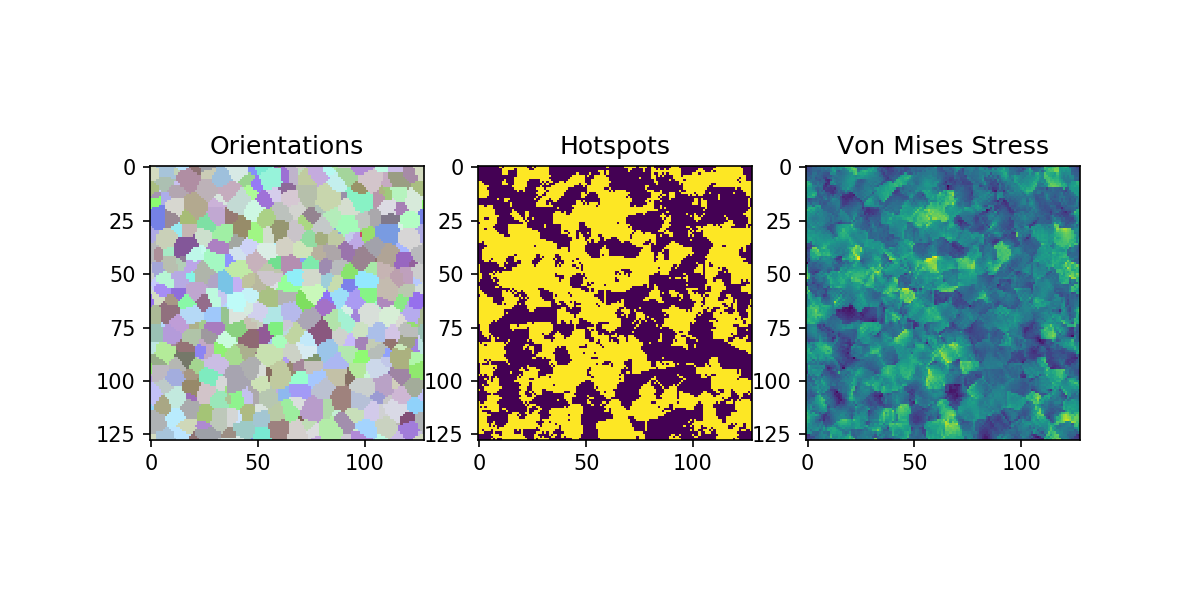

0.499999523163


In [5]:
fig = plt.figure(1,figsize=(8,4))
a=fig.add_subplot(1,3,1)
plt.imshow(fzqu[0]+128) #increasing the values for visualization
a.set_title('Orientations')
a=fig.add_subplot(1,3,2)
plt.imshow(hot50[0])
a.set_title('Hotspots')
a=fig.add_subplot(1,3,3)
plt.imshow(vmstress[0])
a.set_title('Von Mises Stress')
print(np.sum(hot50)/np.prod(hot50.shape))

The human eye isn't very good at determining what's happening, so let's train some convolution kernels to do that! The first step is to create a data generator which samples 2D slices from our orientation data, rotates them around the tensile axis, and crops away the edges. We're going to use 80x80 crops, because 80 is divisible by 16 and that makes calculating the feature map locatoin

In [6]:
def generate_batch(fzqu,hotspots,vmstress):
    slice_index = np.random.randint(0,128)
    rotation = np.random.rand()*360
    rotated_fzqu = imrotate(fzqu[:,:,slice_index], rotation, interp='nearest')
    rotated_hotspots = imrotate(hotspots[:,:,slice_index], rotation, interp='nearest')
    rotated_vmstress = imrotate(vmstress[:,:,slice_index], rotation, interp='nearest')
    
    rotated_hotspots = np.expand_dims(rotated_hotspots,axis=-1)
    rotated_vmstress = np.expand_dims(rotated_vmstress,axis=-1)
    rotated = np.concatenate([rotated_fzqu,rotated_hotspots,rotated_vmstress],axis=-1)
    center = (int(rotated.shape[0]/2),int(rotated.shape[1]/2))
    cropped = rotated[center[0]-40:center[0]+40,center[1]-40:center[1]+40]
    expanded = np.expand_dims(cropped,axis=0)
    
    fz,hot,vm = expanded[:,:,:,:4],expanded[:,:,:,4],expanded[:,:,:,5]
    hot[hot != 0] = 1
    hot = np.expand_dims(hot,axis=-1)
    #not_hot = np.array(np.logical_not(hot),dtype='float32')
    #hot = np.concatenate((hot,not_hot),axis=-1)
    vm = np.expand_dims(vm,axis=-1)
    return fz,hot,vm

Now it's time to define our model.

In [7]:
''' Utility Functions for PixelNet'''
def upsample(input_list):
    output_list = []
    for i,x in enumerate(input_list):
        output = K.repeat_elements(K.repeat_elements(x,2**i,axis=1),2**i,axis=2)
        output_list.append(output)
    return K.concatenate(output_list,axis=3)

def upsample_shape(input_shapes):
    summation = int(np.sum([shape[3] for shape in input_shapes]))
    shape = input_shapes[0]
    return (shape[0],shape[1],shape[2],summation)
    
def im_flatten(x):
    return K.reshape(x,K.stack([-1,x.shape[1]*x.shape[2],x.shape[3]]))

def im_flatten_shape(shape):
    return (shape[0],shape[1]*shape[2],shape[3])

def expand_dims(x):
    return K.expand_dims(x,axis=0)

def expand_dims_shape(shape):
    return (1,shape[0],shape[1])

In [8]:
def w_binary_crossentropy(frequencies):
    scaling = np.prod(frequencies)
    def loss(y_true,y_pred):
        return -scaling*((y_true * K.log(K.clip(y_pred,1e-6,1)))/frequencies[1] + ((1.0 - y_true) * K.log(K.clip(1.0 - y_pred,1e-6,1))/frequencies[0]))
    return loss

In [75]:
def orientation_net(optimizer,frequencies=[1,9]):
    inputs = Input(shape=(80,80,4))
    fmap_list = []
    fdim = 4
    
    X = Conv2D(fdim,(3,3),padding='same')(inputs)
    X = BatchNormalization()(X)
    X = LeakyReLU(alpha=0.3)(X)
    fmap_list.append(X)
    X = MaxPooling2D((2,2),padding='same')(X)
    X = Conv2D(fdim,(3,3),padding='same')(X)
    X = BatchNormalization()(X)
    X = LeakyReLU(alpha=0.3)(X)
    fmap_list.append(X)
    X = MaxPooling2D((2,2),padding='same')(X)
    X = Conv2D(fdim,(3,3),padding='same')(X)
    X = BatchNormalization()(X)
    X = LeakyReLU(alpha=0.3)(X)
    fmap_list.append(X)
    X = MaxPooling2D((2,2),padding='same')(X)
    X = Conv2D(fdim,(3,3),padding='same')(X)
    X = BatchNormalization()(X)
    X = LeakyReLU(alpha=0.3)(X)
    fmap_list.append(X)
    X = MaxPooling2D((2,2),padding='same')(X)
    X = Conv2D(fdim,(3,3),padding='same')(X)
    X = BatchNormalization()(X)
    X = LeakyReLU(alpha=0.3)(X)
    fmap_list.append(X)
    
    hypercolumns = Lambda(upsample,output_shape=upsample_shape)(fmap_list)
    x = Reshape((80*80,fdim*5))(hypercolumns)
    x = Dropout(0.25)(x)
    x = Dense(32)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.3)(x)
    hotspots = Dense(1,activation='sigmoid')(x)
    model = Model(inputs=inputs,outputs=hotspots)
    model.compile(optimizer=optimizer,loss='binary_crossentropy')
    return model

Now let's define a little function for testing hyperparameters. We'll implement Bayesian hyperparameter optimization using this function later on.

In [10]:
def train_with_params(params,epochs):
        optimizer = Adam(lr=params[0],decay=params[1])
        loss = []
        batch_size = 16
        net = orientation_net(optimizer)
        for e in range(epochs):
            im_batch,hot_batch,vm_batch = generate_batch(fzqu,hot50,vmstress)
            for _ in range(batch_size-1):
                im,hot,vm = generate_batch(fzqu,hotspots,vmstress)
                im_batch,hot_batch,vm_batch = np.vstack((im_batch,im)),\
                                              np.vstack((hot_batch,hot)),np.vstack((vm_batch,vm))
            hot_batch,vm_batch = hot_batch.reshape(batch_size,80,80,1),vm_batch.reshape(batch_size,-1,1)
            ce = net.train_on_batch(im_batch,hot_batch)
            loss.append(ce)
            
        mean_loss = np.mean(loss[int(epochs/2):])
        print('Learning Rate: {}, Decay: {} -> Loss: {}'.format(params[0],params[1],mean_loss))
        return net,mean_loss

In [ ]:
with tf.device('/gpu:0'):
    initial_params = np.array([[1e-2,1e-3],[1e-3,1e-3],[1e-4,1e-3],
                               [1e-2,1e-4],[1e-3,1e-4],[1e-4,1e-4],
                               [1e-3,1e-4],[1e-4,1e-4],[1e-5,1e-4],
                               [1e-3,1e-5],[1e-4,1e-5],[1e-5,1e-5],
                               [1e-4,1e-5],[1e-5,1e-5],[1e-6,1e-5],
                               [1e-4,1e-6],[1e-5,1e-6],[1e-6,1e-6],
                               [1e-5,1e-6],[1e-6,1e-6],[1e-7,1e-6],
                               [1e-5,1e-7],[1e-6,1e-7],[1e-7,1e-7],
                               [1e-6,1e-7],[1e-7,1e-7],[1e-8,1e-7],
                               [1e-6,1e-8],[1e-7,1e-8],[1e-8,1e-8]])
    losses = []
    for params in initial_params:
        losses.append(train_with_params(params,100)[1])

<IPython.core.display.Javascript object>


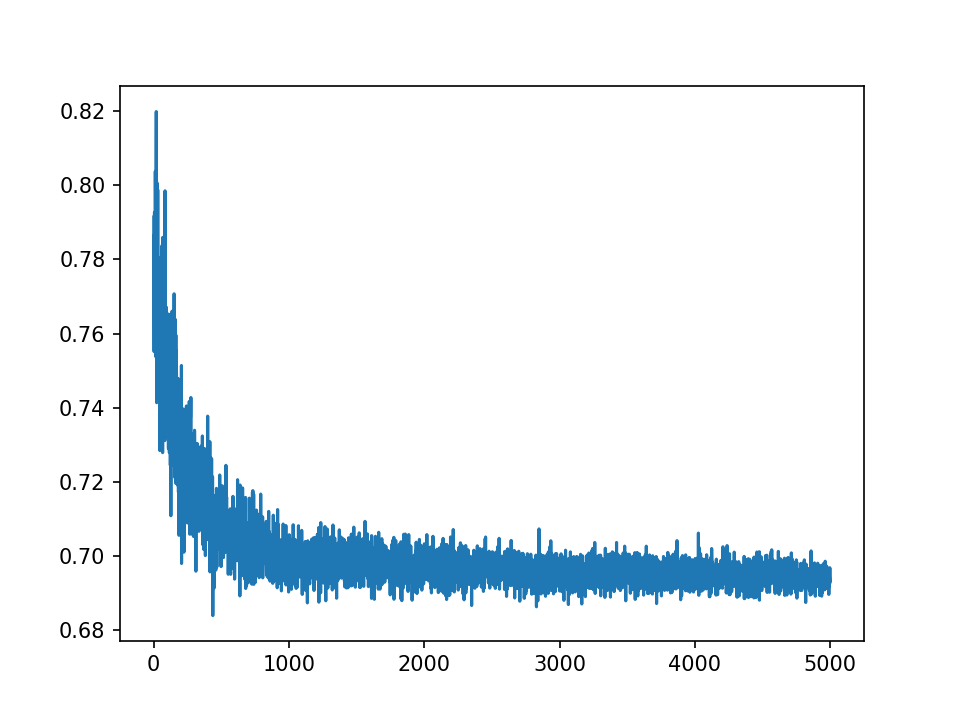

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [76]:
params = [1e-4,1e-5]
fig = plt.figure(2)
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

with tf.device('/gpu:0'):    
    optimizer = Adam(lr=params[0],decay=params[1])
    loss = []
    batch_size = 1
    epochs = 5000
    epoch_array = []
    net = orientation_net(optimizer)
    for e in range(epochs):
        im_batch,hot_batch,vm_batch = generate_batch(fzqu,hot50,vmstress)
        for _ in range(batch_size-1):
            im,hot,vm = generate_batch(fzqu,hotspots,vmstress)
            im_batch,hot_batch,vm_batch = np.vstack((im_batch,im)),\
                                          np.vstack((hot_batch,hot)),np.vstack((vm_batch,vm))
        hot_batch,vm_batch = hot_batch.reshape(batch_size,-1,1),vm_batch.reshape(batch_size,-1,1)
        ce = net.train_on_batch(im_batch,hot_batch)
        loss.append(ce)
        epoch_array.append(e+1)
        
        ax.clear()
        ax.plot(epoch_array,loss)
        fig.canvas.draw()

<IPython.core.display.Javascript object>


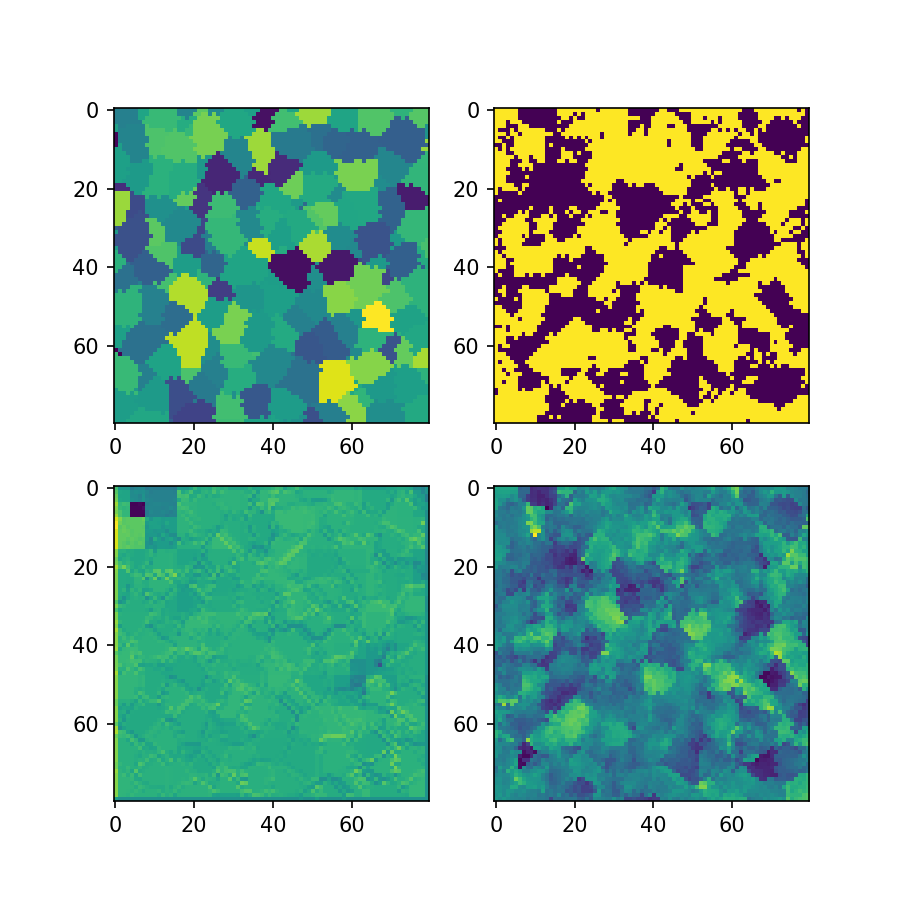

In [69]:
fig = plt.figure(4,figsize=(6,6))
im_batch,hot_batch,vm_batch = generate_batch(fzqu,hot50,vmstress)
prediction = net.predict(im_batch).reshape(80,80)
ax = fig.add_subplot(221)
ax.imshow(100*np.sum(im_batch,axis=-1)[0])
ax = fig.add_subplot(222)
ax.imshow(hot_batch[0,:,:,0])
ax = fig.add_subplot(223)
ax.imshow(prediction)
ax = fig.add_subplot(224)
ax.imshow(vm_batch[0,:,:,0])

In [70]:
feature_visualization = Sequential()

In [74]:
for i,layer in enumerate(net.layers):
    if i < 11 and i > 0:
        feature_visualization.add(layer)

TypeError: 'Tensor' object is not iterable.